# 55 RNN

## 1 循环神经网络的从零开始实现

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 1.1 独热编码（one-hot encoding）
简言之，将每个索引映射为相互不同的单位向量:假设词表中不同词元的数目为N(即len(vocab))，词元索引的范围为0到N-1。如果词元的索引是整数i，那么我们将创建一个长度为N的全0向量，并将第i处的元素设置为1。此向量是原始词元的一个独热向量。
</br>
索引为0和2的独热向量如下所示:

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

每次采样的小批量数据形状是二维张量：（批量大小，时间步数）。 </br>
one_hot函数将这样一个小批量数据转换成三维张量，张量的最后一个维度等于词表大小（len(vocab)）。</br>
我们经常转换输入的维度，以便获得形状为（时间步数，批量大小，词表大小）的输出。</br>
这将使我们能够更方便地通过最外层的维度 一步一步地更新小批量数据的隐状态。

In [3]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### 1.2 初始化模型参数
接下来，我们初始化循环神经网络模型的模型参数。 隐藏单元数num_hiddens是一个可调的超参数。 当训练语言模型时，输入和输出来自相同的词表。 因此，它们具有相同的维度，即词表的大小。

In [4]:
def get_params(vocab_size, num_hiddens, device):
    # 输入的词经过onehot后是长为vocab_size的向量，输出就是预测下一个词，也得是长为vocab_size的向量
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 1.3 循环神经网络模型

为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。

In [5]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。</br>
循环神经网络模型通过inputs最外层的维度实现循环，以便逐时间步更新小批量数据的隐状态H。</br>
此外，这里使用tanh函数作为激活函数。


In [11]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    # 对于每个时间步中的输入 X，它通过 RNN 的前向计算，更新隐藏状态 H 和计算输出 Y。
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    # 最后，将所有时间步的输出连接起来，并返回形状为 (时间步数量 * 批量大小, 词表大小) 的输出张量，以及最终的隐藏状态。
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数， 并存储从零开始实现的循环神经网络模型的参数。

In [12]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状。 例如，隐状态的维数是否保持不变

In [13]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是（时间步数 * 批量大小，词表大小）， 而隐状态形状保持不变，即（批量大小，隐藏单元数）

### 1.4 预测
让我们首先定义预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串。</br> 
在循环遍历prefix中的开始字符时， 我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。这被称为预热（warm-up）期，因为在此期间模型会自我更新（例如，更新隐状态），但不会进行预测。 </br> 
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，从而预测字符并输出它们。</br> 

In [14]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    #  outputs是一个列表，用于存储生成的字符的索引。首先，将前缀的第一个字符( 'prefix[0]"）对应的索引加入outputs。
    outputs = [vocab[prefix[0]]]

    # 这行代码定义了一个匿名函数 get_input，用于获取下一个时间步的输入。
    # 它从 outputs 中获取最后一个生成的字符的索引，将其转换为张量，并将其形状调整为 (1, 1)，以适应模型的输入要求。
    def get_input(): return torch.tensor(
        [outputs[-1]], device=device).reshape((1, 1))

    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # 'y.argmax(dim=1)’的目的是找出RNN模型生成的概率分布中具有最高概率的字符的索引。这个操作可以用来选择在给定时间步生成的字符，即预测的字符。
        # 通常，`y`是一个形状为`(1,vocab_size)的张量，其中‘vocab_size’表示词汇表的大小，每个元素对应一个可能的字符。'argmax(dim=1)’这个操作会沿着`dim=1’(水平维度）找出每行中具有最高值的索引。在这里，它的目的是找出在当前时间步具有最高概率的字符的索引。
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 最后，生成的字符索引被转换为文本字符，并通过''.join()连接成一个字符串，返回生成的文本。
    return ''.join([vocab.idx_to_token[i] for i in outputs])

现在可以测试predict_ch8函数。我们将前缀指定为time traveller，并基于这个前缀生成10个后续字符。鉴于我们还没有训练网络，它会生成荒谬的预测结果。

In [15]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller tvmszkqrat'

### 1.5 梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac {\theta}{ \| \mathbf{g} \|} \right) \mathbf{g} $$

In [16]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 这行代码计算参数梯度的 L2 范数（欧几里得范数）。它遍历参数列表 params，计算每个参数的梯度的平方和，然后取平方根，得到梯度的 L2 范数。
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        # 这行代码对每个参数的梯度进行裁剪。具体地，它将参数的梯度按比例缩放，使梯度的范数等于‘theta'。这个操作确保梯度的范数不会超过指定的阈值`theta`。
        for param in params:
            param.grad[:] *= theta / norm

### 1.6 训练
在训练模型之前，让我们定义一个函数在一个迭代周期内训练模型。它与我们训练3.6节模型的方式有三个不同之处。</br> 
1.序列数据的不同采样方法(随机采样和顺序分区）将导致隐状态初始化的差异。</br> 
⒉.我们在更新模型参数之前裁剪梯度。这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。</br> 
3.我们用困惑度来评价模型。如8.4.4节所述，这样的度量确保了不同长度的序列具有可比性。</br> 
具体来说，当使用顺序分区时，我们只在每个迭代周期的开始位置初始化隐状态。由于下一个小批量数据中的第i个子序列样本与当前第i个子序列样本相邻，因此当前小批量数据最后一个样本的隐状态，将用于初始化下一个小批量数据第一个样本的隐状态。这样，存储在隐状态中的序列的历史信息可以在一个迭代周期内流经相邻的子序列。然而，在任何一点隐状态的计算，都依赖于同一迭代周期中前面所有的小批量数据，这使得梯度计算变得复杂。为了降低计算量，在处理任何一个小批量数据之前，我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。</br> 
当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，因此需要为每个迭代周期重新初始化隐状态。与3.6节中的train_epoch_ch3函数相同，updater是更新模型参数的常用函数。它既可以是从头开始实现的d21.sgd函数，也可以是深度学习框架中内置的优化函数。


In [17]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现， 也可以使用高级API来实现

In [18]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        def updater(batch_size): return d2l.sgd(net.params, lr, batch_size)

    def predict(prefix): return predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在，我们训练循环神经网络模型。 因为我们在数据集中只使用了10000个词元， 所以模型需要更多的迭代周期来更好地收敛。

困惑度 1.0, 91586.9 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


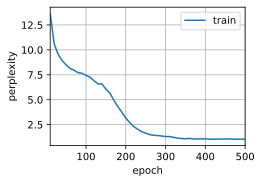

In [19]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果

困惑度 1.4, 90484.6 词元/秒 cuda:0
time travellerit s against reason said filbycan a cube that does
travellerit s against reason said filbycan a cube that does


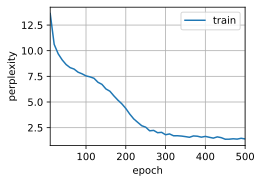

In [20]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

##### 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本
##### 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
##### 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同
##### 当使用顺序划分时，我们需要分离梯度以减少计算量。
##### 在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐状态)
##### 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

## 2 循环神经网络的简洁实现

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 2.1 定义模型
构造一个具有256个隐藏单元的单隐藏层的循环神经网络层rnn_layer

In [25]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

使用张量来初始化隐状态，它的形状是（隐藏层数，批量大小，隐藏单元数）

In [26]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。 需要强调的是，rnn_layer的“输出”（Y）不涉及输出层的计算： 它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入

In [27]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
# Y是中间隐藏层的输出 Y的第一维是时间 第二维批量 第三维度是输出 这里Y并不是输出 而是最后一个隐藏层 所以这里的最后的维度是256 而不是len(vocab)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

为一个完整的循环神经网络模型定义了一个RNNModel类。 注意，rnn_layer只包含隐藏的循环层，我们还需要创建一个单独的输出层。

In [28]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        # Y原本形状是 (时间步数, 批量大小, 隐藏单元数)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

### 2.2 训练与预测

在训练模型之前，让我们基于一个具有随机权重的模型进行预测

In [29]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerieeeeni ii'

很明显，这种模型根本不能输出好的结果。 接下来，我们使用8.5节中定义的超参数调用train_ch8，并且使用高级API训练模型。

perplexity 1.3, 346017.5 tokens/sec on cuda:0
time traveller but now you be in time as all tave that ve yon th
travelleryof cerivind filby the foom the other wardiss they


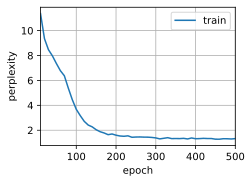

In [30]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

#### 深度学习框架的高级API提供了循环神经网络层的实现。
#### 高级API的循环神经网络层返回一个输出和一个更新后的隐状态，我们还需要计算整个模型的输出层。
#### 相比从零开始实现的循环神经网络，使用高级API实现可以加速训练。